# Reproduction of kaggle first place

Based on:

https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266385

https://www.kaggle.com/code/ligtfeather/eca-nfnet-sam-opt-mixup-k-folds-w-b

First place solution architecture:

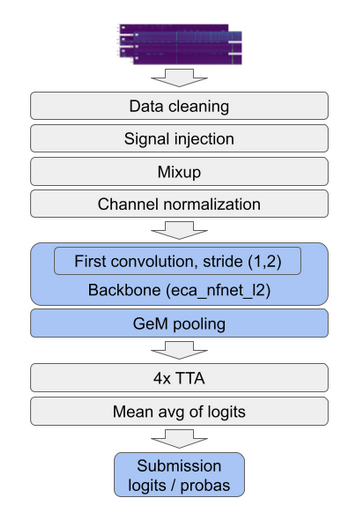

In [1]:
# !pip install timm
# !pip install albumentations
# !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
# !pip install torchsummary

In [48]:
import os
import random
from tqdm import tqdm
from collections import defaultdict
from datetime import datetime
from itertools import chain

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torchsummary import summary
from sklearn.decomposition import NMF
from torch.cuda.amp import GradScaler
from torchvision import utils

import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report

import numpy as np
import pandas as pd
import timm
from adamp import AdamP

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import wandb
from matplotlib import pyplot as plt

In [3]:
config = {
    'num_workers': 4,
    'model': 'eca_nfnet_l0',
    'device': 'cuda',
    'image_size': 224,
    'input_channels': 1,
    'output_features': 1,
    'seed': 42,
    'target_size': 1,
    'T_max': 10,
    'min_lr': 1e-6,
    'lr': 1e-4,
    'weight_decay': 1e-6,
    'batch_size': 50,
    'epochs': 50,
    'num_folds': 1
}

In [4]:
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seeds(seed=config['seed'])

# Data Loading

In [5]:
train_data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train'
labels_filepath = os.path.join(train_data_dir, '500_balanced_labels.npy')

with open(labels_filepath, 'rb') as f:
    initial_data = np.load(f, allow_pickle=True)
    
initial_data_df = pd.DataFrame(initial_data, columns=['id', 'target', 'image_filepath']).convert_dtypes()
initial_data_df['target'] = initial_data_df['target'].astype('int')

## Shuffle data

In [6]:
initial_data_df = initial_data_df.sample(frac=1).reset_index(drop=True)

In [7]:
initial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1000 non-null   string
 1   target          1000 non-null   int32 
 2   image_filepath  1000 non-null   string
dtypes: int32(1), string(2)
memory usage: 19.7 KB


Split the data into 70% train and 30% test:

In [8]:
data_split_mask = np.random.rand(len(initial_data_df)) < 0.7

train_df = initial_data_df[data_split_mask]
test_df = initial_data_df[~data_split_mask]

# Custom Dataset

In [9]:
def resize_image(image):
    return cv2.resize(image, dsize=(config['image_size'], config['image_size']), interpolation=cv2.INTER_CUBIC)


def plot_image(image):
    plt.figure(figsize = (20, 6))
    plt.imshow(image, aspect='auto')
    plt.show()


def normalise_image(image):
    image_min = image.min()
    image_max = image.max()

    return (image - image_min) / (image_max - image_min)


def get_decomposition_matrices(image):
    model = NMF(n_components=2, init='random', random_state=0)
    W = model.fit_transform(image + 100) # add 100 to ensure no negative values
    H = model.components_

    return (W, H)


def get_denoised_image(sample_images):
    combined_on_images = None
    combined_off_images = None
    combined_denoised_image = None

    for i in range(0, len(sample_images), 2):
        on_target_image = sample_images[i]
        off_target_image = sample_images[i+1]

        on_W, on_H = get_decomposition_matrices(on_target_image)
        off_W, off_H = get_decomposition_matrices(off_target_image)
        denoised_image = normalise_image(on_target_image - np.matmul(on_W, off_H))

        combined_on_images = on_target_image if combined_on_images is None else combined_on_images + on_target_image
        combined_off_images = off_target_image if combined_off_images is None else combined_off_images + off_target_image
        combined_denoised_image = denoised_image if combined_denoised_image is None else combined_denoised_image + denoised_image

    return combined_denoised_image

In [10]:
class CustomDataset(Dataset):
    def __init__(self, images_filepaths, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        images_filepath = self.images_filepaths[idx]
        images = np.load(images_filepath).astype(np.float32)
        image = get_denoised_image(images)

        if self.transform is not None:
            image = self.transform(image=image)['image']
        else:
            image = resize_image(image)
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()

        label = torch.tensor(self.targets[idx]).float()

        return image, label

# Image Augmentation

In [11]:
def get_train_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(config['image_size'], config['image_size']),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            albumentations.RandomBrightnessContrast(brightness_limit=0.6, p=0.5),
            albumentations.CoarseDropout(max_holes=10, max_height=12, max_width=12, fill_value=0),
            albumentations.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.1, rotate_limit=0),
            ToTensorV2(p=1.0),
        ]
    )

def get_valid_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(config['image_size'],config['image_size']),
            ToTensorV2(p=1.0)
        ]
    )

def get_test_transforms():
        return albumentations.Compose(
            [
                albumentations.Resize(config['image_size'], config['image_size']),
                ToTensorV2(p=1.0)
            ]
        )

## Mixup

In [12]:
def mixup(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]

    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Loss and ROC Monitoring

In [13]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

def use_roc_score(output, target):
    try:
        y_pred = torch.sigmoid(output).cpu()
        y_pred = y_pred.detach().numpy()
        target = target.cpu()

        return roc_auc_score(target, y_pred)
    except:
        return 0.5

# Weight Random Sampler

In [14]:
def get_sampler(train_data):
    class_counts = train_data['target'].value_counts().to_list()
    num_samples = sum(class_counts)
    labels = train_data['target'].to_list()

    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    weights = [class_weights[labels[i]] for i in range(int(num_samples))]

    return WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

# Train and Validation Dataloaders

In [15]:
def get_loaders(train_data, valid_data, sampler):
    training_set = CustomDataset(
        images_filepaths=train_data['image_filepath'].values,
        targets=train_data['target'].values,
        # transform = get_train_transforms()
    )

    validation_set = CustomDataset(
        images_filepaths=valid_data['image_filepath'].values,
        targets=valid_data['target'].values,
        # transform = get_valid_transforms()
    )

    train_loader = DataLoader(
        training_set,
        batch_size = config['batch_size'],
        shuffle=True,
        # num_workers=config['num_workers'],
        # sampler = sampler,
        pin_memory = True
    )

    valid_loader = DataLoader(
        validation_set,
        batch_size = config['batch_size'],
        shuffle = False,
        # num_workers=config['num_workers'],
        pin_memory = True
    )

    return train_loader, valid_loader

# Model

In [16]:
# https://machinelearningknowledge.ai/pytorch-conv2d-explained-with-examples/#Example_of_PyTorch_Conv2D_in_CNN

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=2),
            # nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(p=0.1)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=2),
            # nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(p=0.1)
        )

        # self.layer3 = nn.Sequential(
        #     nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=2),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.Dropout(p=0.1)
        # )

        self.fc1 = nn.Linear(12544, 1, bias=True) # 50x2048 and 107648x625

        # nn.init.xavier_uniform(self.fc1.weight)

        self.layer4 = nn.Sequential(
            self.fc1,
            # nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        #
        # self.fc2 = torch.nn.Linear(625, 1, bias=True)
        #
        # torch.nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        x = x.view(x.size(0), -1) # flatten for FC
        x = self.fc1(x)
        # x = self.fc2(x)

        return x

In [17]:
layers = nn.Sequential(
            # nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            #
            # nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            #
            # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            #
            # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            # nn.Linear(in_features=224*224, out_features=1),
            # nn.Linear(in_features=16*53, out_features=16*53),
            # nn.Linear(in_features=16*53, out_features=1)

            nn.Linear(224, 64)
        )

def shape_of_output(shape_of_input, list_of_layers):
    sequential = nn.Sequential(*list_of_layers)
    return tuple(sequential(torch.rand(1, *shape_of_input)).shape)

shape_of_output((1, 224, 224), layers)

(1, 1, 224, 64)

# Initialise Model, Loss Function, Optimizer and Scheduler

In [18]:
model = CustomModel()
model = model.to(config['device'])

criterion = nn.BCEWithLogitsLoss().to(config['device'])
# base_optimizer = AdamP
# optimizer = SAM(model.parameters(), base_optimizer, lr=config['lr'], weight_decay=config['weight_decay'])

# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

scheduler = CosineAnnealingLR(optimizer,
                              T_max=config['T_max'],
                              eta_min=config['min_lr'],
                              last_epoch=-1)

In [19]:
print(model.cuda())

CustomModel(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=12544, out_features=1, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=12544, out_features=1, bias=True)
    (1): Dropout(p=0.1, inplace=False)
  )
)


In [20]:
# summary(model.cuda(), (1, 12, 64)) # (channels, H, W)

# K-Fold CV

In [21]:
def train(train_loader, model, criterion, optimizer, epoch, scheduler):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(enumerate(train_loader), total=len(train_loader))

    for i, (images, target) in stream:
        images = images.to(config['device'])
        target = target.to(config['device']).float().view(-1, 1)
        # images, targets_a, targets_b, lam = mixup(images, target.view(-1, 1))

        optimizer.zero_grad()

        output = model(images)

        # loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
        loss = criterion(output, target.unsqueeze(1))
        loss.backward(retain_graph=True)

        # optimizer.first_step(zero_grad=False)
        # optimizer.zero_grad()

        # mixup_criterion(criterion, model(images), targets_a, targets_b, lam).backward()
        # optimizer.second_step(zero_grad=False)

        roc_score = use_roc_score(output, target)

        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('ROC', roc_score)

        wandb.log({'Train Epoch': epoch, 'Train loss': loss.item(), 'Train ROC': roc_score})

        stream.set_description('Epoch: {epoch}. Train. {metric_monitor}'
                               .format(epoch=epoch, metric_monitor=metric_monitor))

    scheduler.step()

In [22]:
def validate(val_loader, model, criterion, epoch):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(enumerate(val_loader), total=len(val_loader))
    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for i, (images, target) in stream:
            images = images.to(config['device'], non_blocking=True)
            target = target.to(config['device'], non_blocking=True).float().view(-1, 1)

            output = model(images)
            loss = criterion(output, target)
            roc_score = use_roc_score(output, target)

            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('ROC', roc_score)

            wandb.log({"Valid Epoch": epoch, "Valid loss": loss.item(), "Valid ROC":roc_score})

            stream.set_description("Epoch: {epoch}. Validation. {metric_monitor}"
                                   .format(epoch=epoch, metric_monitor=metric_monitor))
            
            targets = target.detach().cpu().numpy().tolist()
            outputs = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(outputs)

    return final_outputs, final_targets

# W&B Initialisation for K-Fold CV

**W&B API key**: 47b00b0f6291346fe94ab4a6dceca03a809fbf4a

# Training loop

Create directory to save models for this run:

In [23]:
current_datetime = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
models_dir = os.path.join('models', current_datetime)

os.mkdir(models_dir)

Execute the training loop:

In [24]:
train_data = train_df.iloc[:400,:]
valid_data = train_df.iloc[400:,:]
train_loader, valid_loader = get_loaders(train_df, valid_data, None)

# sampler = get_sampler(train_data)


model.train()

for e in range(1, config['epochs']+1):
    epoch_loss = 0
    epoch_acc = 0

    for X_batch, y_batch in train_loader:
        # print('y batch:', y_batch)

        # X_batch is the batched image samples
        # y_batch is the batched labels
        X_batch, y_batch = X_batch.to(config['device']), y_batch.to(config['device'])

        optimizer.zero_grad()

        predictions = model(X_batch)

        # print('predictions:', predictions)

        loss = criterion(predictions, y_batch.unsqueeze(1))
        # acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # epoch_acc += acc.item()


    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 5244.70976 | Acc: 0.000
Epoch 002: | Loss: 1690.87102 | Acc: 0.000
Epoch 003: | Loss: 472.77378 | Acc: 0.000
Epoch 004: | Loss: 223.34161 | Acc: 0.000
Epoch 005: | Loss: 169.89095 | Acc: 0.000
Epoch 006: | Loss: 67.87609 | Acc: 0.000
Epoch 007: | Loss: 24.73295 | Acc: 0.000
Epoch 008: | Loss: 11.42270 | Acc: 0.000
Epoch 009: | Loss: 5.02867 | Acc: 0.000
Epoch 010: | Loss: 2.80429 | Acc: 0.000
Epoch 011: | Loss: 3.46085 | Acc: 0.000
Epoch 012: | Loss: 2.48944 | Acc: 0.000
Epoch 013: | Loss: 0.99453 | Acc: 0.000
Epoch 014: | Loss: 1.45120 | Acc: 0.000
Epoch 015: | Loss: 1.74854 | Acc: 0.000
Epoch 016: | Loss: 4.06659 | Acc: 0.000
Epoch 017: | Loss: 2.16853 | Acc: 0.000
Epoch 018: | Loss: 1.30627 | Acc: 0.000
Epoch 019: | Loss: 1.69803 | Acc: 0.000
Epoch 020: | Loss: 1.27110 | Acc: 0.000
Epoch 021: | Loss: 1.14575 | Acc: 0.000
Epoch 022: | Loss: 0.76102 | Acc: 0.000
Epoch 023: | Loss: 0.66955 | Acc: 0.000
Epoch 024: | Loss: 0.68798 | Acc: 0.000
Epoch 025: | Loss: 0.6136

# Analysis

## Run best performing model against test set

In [25]:
def get_test_loader(test_data):
    test_set = CustomDataset(
        images_filepaths=test_data['image_filepath'].values,
        targets=test_data['target'].values,
        # transform=get_valid_transforms()
    )

    return DataLoader(
        test_set,
        batch_size=config['batch_size'],
        shuffle=False,
        # num_workers=config['num_workers'],
        pin_memory=True
    )

In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 995
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              302 non-null    string
 1   target          302 non-null    int32 
 2   image_filepath  302 non-null    string
dtypes: int32(1), string(2)
memory usage: 8.3 KB


In [51]:
test_df['target'].value_counts()

1    166
0    136
Name: target, dtype: int64

In [27]:
loss = 0
acc = 0
test_targets = []
test_outputs = []

model.eval()
test_loader = get_test_loader(test_df)

for X_batch, y_batch in test_loader:
    X_batch, y_batch = X_batch.to(config['device']), y_batch.to(config['device'])

    y_pred = model(X_batch)

    test_targets.append(y_batch)
    test_outputs.extend([t.item() for t in y_pred])

    print(y_batch)
    print(y_pred)

    loss = criterion(y_pred, y_batch.unsqueeze(1))
    # acc = binary_acc(y_pred, y_batch.unsqueeze(1))

    loss += loss.item()
    # epoch_acc += acc.item()


print(f'Loss: {loss/len(test_loader):.5f}')

tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
        1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1.],
       device='cuda:0')
tensor([[ 0.7524],
        [-0.2052],
        [ 0.9644],
        [ 1.8266],
        [ 3.3661],
        [ 1.1382],
        [ 0.5848],
        [-0.6771],
        [-0.4891],
        [ 0.8946],
        [ 0.8047],
        [ 1.7257],
        [ 0.7682],
        [ 0.7449],
        [ 0.1858],
        [ 1.5965],
        [ 2.6176],
        [ 2.7897],
        [ 1.8549],
        [ 0.5794],
        [ 3.0081],
        [ 1.9474],
        [ 2.6014],
        [-0.2271],
        [-1.9588],
        [ 0.4293],
        [ 0.8101],
        [ 1.7911],
        [ 0.2965],
        [ 1.2256],
        [-0.7422],
        [ 1.3094],
        [ 1.0459],
        [ 1.0873],
        [-0.9805],
        [ 0.2625],
        [ 2.0301],
        [ 0.5588],
        [ 1.6216],
        [ 

Prediction values are in a range:

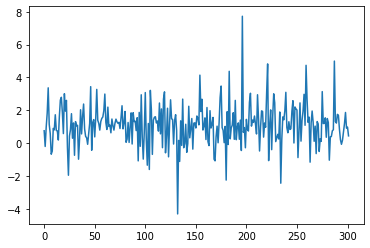

In [35]:
plt.plot(test_outputs)

Normalise between 0, 1 and use 0.5 as threshold for binary classification:

In [38]:
def normalise_predictions(predictions):
    predictions_min = min(predictions)
    predictions_max = max(predictions)

    # return (predictions - predictions_min) / (predictions_max - predictions_min)
    return [(x - predictions_min) / (predictions_max - predictions_min) for x in predictions]


normalised_predictions = normalise_predictions(test_outputs)

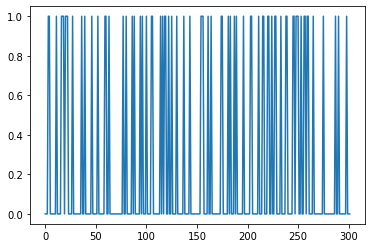

In [46]:
plt.plot(normalised_predictions)

In [43]:
test_targets_float = [x.cpu().numpy() for x in test_targets]
test_targets_float = np.concatenate(test_targets_float, axis=0).tolist()
test_outputs_binary = [0 if x < 0.5 else 1.0 for x in normalised_predictions]

In [44]:
test_results_df = pd.DataFrame([test_targets_float, test_outputs_binary])

test_results_df = test_results_df.transpose()
test_results_df.columns = ['label', 'prediction']

test_results_df

,label,prediction
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,1.0
4,0.0,1.0
...,...,...
297,0.0,0.0
298,1.0,1.0
299,0.0,0.0
300,1.0,0.0


In [45]:
pd.crosstab(test_results_df['prediction'], test_results_df['label'])

label,0.0,1.0
prediction,,
0.0,99,128
1.0,37,38


In [52]:
print(classification_report(test_results_df['label'], test_results_df['prediction']))

              precision    recall  f1-score   support

         0.0       0.44      0.73      0.55       136
         1.0       0.51      0.23      0.32       166

    accuracy                           0.45       302
   macro avg       0.47      0.48      0.43       302
weighted avg       0.47      0.45      0.42       302



# Visualise filters

In [31]:
# https://stackoverflow.com/questions/55594969/how-to-visualise-filters-in-a-cnn-with-pytorch

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))
        grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [32]:
model = CustomModel()
model.load_state_dict(torch.load(os.path.join(models_dir, 'eca_nfnet_l0_fold_1_epoch_1_roc_auc_0.529.pth')))
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'models\\22-08-29_23-48-43\\eca_nfnet_l0_fold_1_epoch_1_roc_auc_0.529.pth'

In [ ]:
# get the kernels from the first layer
# as per the name of the layer
kernels = model.fc4.weight.detach().clone()

#check size for sanity check
print(kernels.size())

# normalize to (0,1) range so that matplotlib
# can plot them
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
filter_img = utils.make_grid(kernels, nrow = 12)
# change ordering since matplotlib requires images to
# be (H, W, C)
plt.imshow(filter_img.permute(1, 2, 0))